In [ ]:
# Install python pacakges
!pip install -q scikit-optimize # install the package used for Bayesian optimization
!pip install scikit-learn
# !pip install -q scikeras[tensorflow]
!pip install -q numpy == 2.0
!pip install -q tensorflow==2.18.0
!pip install -q keras-tuner
!pip install -q iterative-stratification
!pip install -q pyreadr
!pip install -q lifelines
!pip install smogn pandas numpy scikit-learn
!pip install scikit_posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.8 MB/s eta 0:00:00
ERROR: Invalid requirement: '==': Expected package name at the start of dependency specifier
    ==
    ^
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.18.0 which is incompatible.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.0 whi

In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time
import joblib
import json

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks"

# choose where you want your project files to be saved
project_folder = "/SOT-nano-2025/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive



# **Data exploration**


In [ ]:
# Import recoded nano info
Nano_info = pyreadr.read_r(os.path.join(root_dir + project_folder + "Nanotoxicity info.RDS"))
Nano_info = Nano_info[None]

In [ ]:
Nano_info_data=pd.DataFrame(Nano_info)

In [ ]:
Nano_info_data.columns = ["Dataset No.", "PT", "INM", "ONM", "TS", "NMID", "Shape", "SC", "PDI", "TEM",
               "HD", "ZP", "TM", "CT", "TumorCell", "Drug1", "Dose1", "Drug2", "Dose2","DoseFreq",
               "Sex", "Animal", "Srain", "AP", "AT", "MM", "logHD", "HDCat", "CoDelivery","ONMcat", "INMcat", "MAT","Cancer"]
selected_columns = ["Dataset No.", "PT", "INMcat", "ONMcat", "MAT", "Shape", "TS","HD", "logHD", "HDCat",
            "ZP", "TM", "CT", "Cancer", "AT", "MM", "CoDelivery"]
Nano_info_slt =Nano_info_data[selected_columns]
Nano_info_slt.isna().sum()

,0
Dataset No.,0
PT,0
INMcat,0
ONMcat,0
MAT,0
Shape,0
TS,0
HD,23
logHD,23
HDCat,23


In [ ]:
unique_tm_values = Nano_info_slt["TM"].unique()
print("Unique TM values:", unique_tm_values)
# ✅ Standardized TM Mapping
tm_mapping = {
    "Allograft Orthotopic ": "Allograft Orthotopic",
    "Allograft Heterotopic": "Allograft Heterotopic",
    "Xenograft Heterotopic": "Xenograft Heterotopic",
    "Healthy": "Healthy",
    "Xenograft Orthotopic": "Xenograft Orthotopic",
    "Allograft Orthotopic": "Allograft Orthotopic",
    "Healty": "Healthy",
    "Allograft heterotopic": "Allograft Heterotopic",  # Fix capitalization
    "xenograft heterotopic": "Xenograft Heterotopic"  # Fix capitalization
}
Nano_info_slt["TM"] = Nano_info_slt["TM"].str.strip().replace(tm_mapping)
print("Cleaned TM values:", Nano_info_slt["TM"].unique())

Unique TM values: ['Allograft Orthotopic ' 'Allograft Heterotopic' 'Xenograft Heterotopic'
 'Healthy' 'Xenograft Orthotopic' 'Allograft Orthotopic' 'Healty'
 'Allograft heterotopic' 'xenograft heterotopic']
Cleaned TM values: ['Allograft Orthotopic' 'Allograft Heterotopic' 'Xenograft Heterotopic'
 'Healthy' 'Xenograft Orthotopic']


<ipython-input-7-1a145d899a94>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nano_info_slt["TM"] = Nano_info_slt["TM"].str.strip().replace(tm_mapping)


In [ ]:
# Import Data of biomarkers
Data = pd.read_csv(os.path.join(root_dir + project_folder + "ToxicityDataset_20250211.csv"))
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dataset No.               214 non-null    float64
 1   Particle Type             214 non-null    object 
 2   Inorganic Material        57 non-null     object 
 3   Organic Material          162 non-null    object 
 4   Targeting Strategy        214 non-null    object 
 5   NM ID                     214 non-null    object 
 6   NM Shape                  214 non-null    object 
 7   Surface Charge            165 non-null    object 
 8   PDI                       124 non-null    float64
 9   NM TEM Size (nm)          47 non-null     float64
 10  NM Hydrodnamic Size (nm)  191 non-null    float64
 11  Zeta Potential (mV)       161 non-null    float64
 12  Tumour Model              214 non-null    object 
 13  Cancer Type               214 non-null    object 
 14  Tumor Cell

In [ ]:
#Fill the Dataset No.
Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')

<ipython-input-9-9a2d06756a62>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')


In [ ]:
#Calculate the biomarker level change between DLNP group and the control group
Data['ALT%'] = Data['ALT_DLNP']/Data['ALT_Ctrl']-1
Data['AST%'] = Data['AST_DLNP']/Data['AST_Ctrl']-1
Data['BUN%'] = Data['BUN_DLNP']/Data['BUN_Ctrl']-1
Data['CREA%'] = Data['CREA_DLNP']/Data['CREA_Ctrl']-1
Data_biomarkers = Data[['Dataset No.','ALT%', 'AST%', 'BUN%', 'CREA%']]

# **Data_CREA Construction**

## **Original Data Construction**

In [ ]:
# Data_CREA construction
# Select only relevant columns
Data_Dose = Data[['Dataset No.', 'Dose_1','Dose_2','Dose frequency']].dropna(subset=['Dataset No.']).reset_index(drop=True)
Data_Dose['Dose'] = Data_Dose['Dose_1'] + Data_Dose['Dose_2'].fillna(0)
Data_Dose['AccumDose'] = Data_Dose['Dose'] * Data_Dose['Dose frequency']
# Drop the NAs in AccumDose
Data_Dose = Data_Dose.dropna(subset=['AccumDose'])

In [ ]:
Data_Dose

,Dataset No.,Dose_1,Dose_2,Dose frequency,Dose,AccumDose
0,1.0,10.0,5.0,12.0,15.0,180.0
1,2.0,10.0,5.0,12.0,15.0,180.0
2,3.0,10.0,NaN,1.0,10.0,10.0
5,4.0,2.0,2.5,1.0,4.5,4.5
7,5.0,2.5,NaN,1.0,2.5,2.5
...,...,...,...,...,...,...
231,210.0,7.5,NaN,1.0,7.5,7.5
234,211.0,5.0,NaN,1.0,5.0,5.0
235,212.0,5.0,NaN,1.0,5.0,5.0
237,213.0,20.0,12.0,7.0,32.0,224.0


In [ ]:
#Fill the Dataset No.
Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')

<ipython-input-13-9a2d06756a62>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data['Dataset No.'] = Data['Dataset No.'].fillna(method='ffill')


In [ ]:
Data

,Dataset No.,Particle Type,Inorganic Material,Organic Material,Targeting Strategy,NM ID,NM Shape,Surface Charge,PDI,NM TEM Size (nm),...,BUN_Other,CREA_Other,Other_Name,Ref,PMID,Assistive tech,ALT%,AST%,BUN%,CREA%
0,1.0,Organic,NaN,Liposome,Active,FA-DTCR-NLC,Spherical,Positive,0.327,NaN,...,NaN,NaN,NaN,"Rawal, 2021",33215254,NaN,NaN,NaN,-0.147544,-0.357155
1,2.0,Organic,NaN,Liposome,Passive,DTCR-NLCs,Spherical,Positive,0.263,NaN,...,NaN,NaN,NaN,"Rawal, 2021",33215254,NaN,NaN,NaN,-0.130435,-0.321437
2,3.0,Inorganic,Iron,NaN,Passive,DOX@Gd-MFe3O4 NP,Spherical,NaN,NaN,49.0,...,NaN,NaN,NaN,"Zheng, 2021",33866915,NaN,0.009998,0.022985,-0.077423,0.042797
3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.004987,-0.040233,-0.005595,0.005350
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.064998,-0.091952,-0.088432,0.026748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,211.0,Organic,NaN,Polymeric,Passive,PDA-DOX/JQ1,Spherical,Negative,NaN,NaN,...,NaN,NaN,NaN,"Hu, 2024",38979530,NaN,-0.018011,-0.008200,0.023036,NaN
235,212.0,Inorganic,Gold,NaN,Active,HA-AuNF,Spherical,Negative,NaN,NaN,...,NaN,NaN,NaN,"Bariana, 2023",36701696,NaN,1.636327,NaN,0.027816,0.500000
236,212.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,0.054054,0.319994
237,213.0,Inorganic,Silica,NaN,Passive,DMPIM,Plate,Positive,0.300,NaN,...,NaN,NaN,NaN,"Yang, 2024",38697132,Laser,0.037524,0.070655,-0.192336,-0.065340


In [ ]:
# Data_CREA construction
# Select only relevant columns
Data_CREA = Data[['Dataset No.', 'CREA%']]

# Drop rows where "CREA%" is missing
Data_CREA = Data_CREA.dropna(subset=["CREA%"])

# Keep only the row with the largest absolute CREA% value for each Dataset No.
Data_CREA = Data_CREA.reset_index(drop=True)

idx = Data_CREA.groupby("Dataset No.")["CREA%"].apply(lambda x: x.abs().idxmax())

Data_CREA = Data_CREA.loc[idx].reset_index(drop=True)

# Merge Data_Dose and Data_AST on 'Dataset No.'
Data_CREA = pd.merge(Data_CREA, Data_Dose[['Dataset No.','AccumDose']], on='Dataset No.', how='inner')

In [ ]:
Data_CREA

,Dataset No.,CREA%,AccumDose
0,1.0,-0.357155,180.000000
1,2.0,-0.321437,180.000000
2,3.0,0.042797,10.000000
3,4.0,0.023105,4.500000
4,5.0,-0.190999,2.500000
...,...,...,...
158,209.0,-0.069767,0.638298
159,210.0,-0.905688,7.500000
160,212.0,0.500000,5.000000
161,213.0,-0.065340,224.000000


In [ ]:
# Ensure 'Dataset No.' is of the same type in both DataFrames
Data_CREA['Dataset No.'] = pd.to_numeric(Data_CREA['Dataset No.'], errors='coerce')
Nano_info_slt['Dataset No.'] = pd.to_numeric(Nano_info_slt['Dataset No.'], errors='coerce')

dataset_numbers = Data_CREA["Dataset No."].unique()
Nano_info_slt_filtered = Nano_info_slt[Nano_info_slt["Dataset No."].isin(dataset_numbers)].copy
df_CREA = pd.merge(Nano_info_slt, Data_CREA, on="Dataset No.", how = "inner")

<ipython-input-17-06e137614bc7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nano_info_slt['Dataset No.'] = pd.to_numeric(Nano_info_slt['Dataset No.'], errors='coerce')


In [ ]:
df_CREA

,Dataset No.,PT,INMcat,ONMcat,MAT,Shape,TS,HD,logHD,HDCat,ZP,TM,CT,Cancer,AT,MM,CoDelivery,CREA%,AccumDose
0,1,Organic,,Liposome,Liposome,Spherical,Active,180.8,2.257198,100-200,15.000000,Allograft Orthotopic,Lung,Lung,NO,TB,yes,-0.357155,180.000000
1,2,Organic,,Liposome,Liposome,Spherical,Passive,150.2,2.176670,100-200,26.300000,Allograft Orthotopic,Lung,Lung,NO,TB,yes,-0.321437,180.000000
2,3,Inorganic,Iron,,Iron,Spherical,Passive,NaN,NaN,NaN,NaN,Allograft Heterotopic,Breast,Breast,NO,TB,no,0.042797,10.000000
3,4,Inorganic,Iron,,Iron,Spherical,Passive,91.6,1.961895,10-100,21.100000,Allograft Heterotopic,Breast,Breast,NO,TB,yes,0.023105,4.500000
4,5,Inorganic,Iron,,Iron,Spherical,Passive,NaN,NaN,NaN,NaN,Allograft Heterotopic,Breast,Breast,NO,TB,no,-0.190999,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,209,Inorganic,Gold,,Gold,Spherical,Passive,120.0,2.079181,100-200,-5.000000,Allograft Orthotopic,Colon,GI tract,YES,TB,no,-0.069767,0.638298
159,210,Organic,,Polymeric,Polymeric,Spherical,Passive,153.0,2.184691,100-200,-4.150000,Healthy,Healthy,Healthy,NO,healthy,no,-0.905688,7.500000
160,212,Inorganic,Gold,,Gold,Spherical,Active,148.0,2.170262,100-200,-24.385475,Xenograft Heterotopic,lymphoma,Others,NO,TB,no,0.500000,5.000000
161,213,Inorganic,Silica,,Silica,Plate,Passive,195.5,2.291147,100-200,17.486339,Allograft Heterotopic,Cervix,Freproductive,YES,TB,yes,-0.065340,224.000000


In [ ]:
#Save df_AST dataset
df_CREA.to_csv(os.path.join(root_dir + project_folder, "CREA dataset.csv"), index=False)

## **SMOGN data enhancement**

In [ ]:
import smogn  # SMOGN library for regression data augmentation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Read saved SMOGN data
df_CREA = pd.read_csv(os.path.join(root_dir + project_folder + "CREA dataset.csv"))

In [ ]:
df = df_CREA.dropna(subset=['logHD', 'ZP'])

In [ ]:
#Drop the first column ("Dataset No.")
df = df.iloc[:,1:]

In [ ]:
df = df.drop(columns = ["HDCat", "INMcat", "ONMcat", "CT", "HD"], errors='ignore')

In [ ]:
print(df.dtypes)

PT             object
MAT            object
Shape          object
TS             object
logHD         float64
ZP            float64
TM             object
Cancer         object
AT             object
MM             object
CoDelivery     object
CREA%         float64
AccumDose     float64
dtype: object


In [ ]:
#Recoding categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', "float64"]).columns.tolist()

In [ ]:
categorical_cols

['PT', 'MAT', 'Shape', 'TS', 'TM', 'Cancer', 'AT', 'MM', 'CoDelivery']

In [ ]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # One-hot encoding
print(df_encoded.head())

      logHD    ZP     CREA%  AccumDose  PT_Inorganic  PT_Organic  MAT_Gold  \
0  2.257198  15.0 -0.357155     180.00         False        True     False   
1  2.176670  26.3 -0.321437     180.00         False        True     False   
3  1.961895  21.1  0.023105       4.50          True       False     False   
5  1.942653 -11.7  0.006173     102.32         False        True     False   
6  1.942653 -11.7 -0.009259     204.64         False        True     False   

   MAT_Hybrid  MAT_Inorganic others  MAT_Iron  ...  Cancer_Freproductive  \
0       False                 False     False  ...                 False   
1       False                 False     False  ...                 False   
3       False                 False      True  ...                 False   
5       False                 False     False  ...                 False   
6       False                 False     False  ...                 False   

   Cancer_GI tract  Cancer_Healthy  Cancer_Lung  Cancer_Mreproductive  \
0

In [ ]:
# Define X (independent variables) and y (dependent variable)
X = df_encoded.drop(columns=["CREA%"])  # Assuming 'CREA%' is the target variable
y = df_encoded["CREA%"]

In [ ]:
df_smogn_input = X.copy()
df_smogn_input["CREA%"] = y  #Reattach target

In [ ]:
# ✅ Identify Boolean (True/False) Columns
bool_cols = df_smogn_input.select_dtypes(include=["bool"]).columns

# ✅ Convert Only Boolean Columns to Integers (1/0)
df_smogn_input[bool_cols] = df_smogn_input[bool_cols].astype(int)

# ✅ Check BUN% values remain unchanged
df_smogn_input

,logHD,ZP,AccumDose,PT_Inorganic,PT_Organic,MAT_Gold,MAT_Hybrid,MAT_Inorganic others,MAT_Iron,MAT_Liposome,...,Cancer_GI tract,Cancer_Healthy,Cancer_Lung,Cancer_Mreproductive,Cancer_Others,Cancer_Skin,AT_YES,MM_healthy,CoDelivery_yes,CREA%
0,2.257198,15.000000,180.000000,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,-0.357155
1,2.176670,26.300000,180.000000,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,-0.321437
3,1.961895,21.100000,4.500000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0.023105
5,1.942653,-11.700000,102.320000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.006173
6,1.942653,-11.700000,204.640000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.009259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2.079181,-5.000000,0.638298,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-0.069767
159,2.184691,-4.150000,7.500000,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-0.905688
160,2.170262,-24.385475,5.000000,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.500000
161,2.291147,17.486339,224.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,-0.065340


In [ ]:
df_smogn_input["CREA%"] = df_smogn_input["CREA%"] * 100  # Scale by 100
df_smogn_input

,logHD,ZP,AccumDose,PT_Inorganic,PT_Organic,MAT_Gold,MAT_Hybrid,MAT_Inorganic others,MAT_Iron,MAT_Liposome,...,Cancer_GI tract,Cancer_Healthy,Cancer_Lung,Cancer_Mreproductive,Cancer_Others,Cancer_Skin,AT_YES,MM_healthy,CoDelivery_yes,CREA%
0,2.257198,15.000000,180.000000,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,-35.715498
1,2.176670,26.300000,180.000000,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,-32.143665
3,1.961895,21.100000,4.500000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,2.310512
5,1.942653,-11.700000,102.320000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.617284
6,1.942653,-11.700000,204.640000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.925926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2.079181,-5.000000,0.638298,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,-6.976744
159,2.184691,-4.150000,7.500000,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-90.568818
160,2.170262,-24.385475,5.000000,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,50.000000
161,2.291147,17.486339,224.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,-6.533960


In [ ]:
# get 75% of ALT% values
df_smogn_input["CREA%"].quantile(0.75)

np.float64(7.61868300153139)

In [ ]:
# Split the data based on ZP values
df_smogn_input_positive = df_smogn_input[df_smogn_input["ZP"] > 0]
df_smogn_input_negative = df_smogn_input[df_smogn_input["ZP"] <= 0]

#Reset the index to make sure it is continuous and no gap
df_smogn_input_positive = df_smogn_input_positive.reset_index(drop=True)
df_smogn_input_negative = df_smogn_input_negative.reset_index(drop=True)
print(df_smogn_input_positive.shape)
print(df_smogn_input_negative.shape)

(22, 32)
(87, 32)


In [ ]:
#Save df_BUN dataset
df_smogn_input.to_csv(os.path.join(root_dir + project_folder, "smogn input dataset_CREA.csv"), index=False)

In [ ]:
def custom_phi(y):
    # Define a more balanced threshold for relevance
    return np.where(y > np.percentile(y, 75), 1, np.where(y < np.percentile(y, 25), 0, 0.5))

# Apply phi function to check relevance values
y_phi_values = custom_phi(df_smogn_input_positive["CREA%"])
print("Unique relevance values:", np.unique(y_phi_values))

# Apply SMOGN with emphasis on high BUN% values for ZP<0
df_smogn_negative = smogn.smoter(
    data=df_smogn_input_negative,  # Input data
    y="CREA%",  # Target variable
    k= 8,  # Number of nearest neighbors for SMOGN
    pert = 0.02,
    samp_method="extreme",  # Focus on extreme values
    rel_thres=0.60,  # Target extreme values above 80th percentile
    rel_xtrm_type="high",  # Only focus on high ALT% values
    rel_coef=2.0  # Stronger oversampling for extreme values
)

print("Original dataset size:", df_smogn_input_negative.shape)
print("After SMOGN:", df_smogn_negative.shape)

Unique relevance values: [0.  0.5 1. ]


r_index: 100%|##########| 4/4 [00:00<00:00, 197.86it/s]

Original dataset size: (87, 32)
After SMOGN: (153, 32)


In [ ]:
df_smogn_input_positive = resample(
    df_smogn_input_positive,
    replace=True,
    n_samples=50,  # Increase sample size to at least 50
    random_state=52
)

# Apply the custom relevance function
y_phi_values = custom_phi(df_smogn_input_positive["CREA%"])

# Count the distribution of relevance values
unique, counts = np.unique(y_phi_values, return_counts=True)
print("Relevance Score Distribution:", dict(zip(unique, counts)))

# Apply SMOGN with emphasis on high CREA% values for ZP<0, handling NaNs
df_smogn_positive = smogn.smoter(
    data=df_smogn_input_positive.fillna(df_smogn_input_positive.mean()),  # Fill NaNs with mean
    y="CREA%",
    k=5,
    pert=0.02,
    samp_method="extreme",
    rel_thres=0.60,  # Now only top 25% treated as extreme
    rel_xtrm_type="high",
    rel_coef= 2.0
)
print("Original dataset size:", df_smogn_input_positive.shape)
print("After SMOGN:", df_smogn_input_positive.shape)

Relevance Score Distribution: {np.float64(0.0): np.int64(13), np.float64(0.5): np.int64(24), np.float64(1.0): np.int64(13)}


r_index: 100%|##########| 1/1 [00:00<00:00, 214.72it/s]

Original dataset size: (50, 32)
After SMOGN: (50, 32)


In [ ]:
#Combine the smogn datasets
df_smogn = pd.concat([df_smogn_positive, df_smogn_negative], ignore_index = True)
df_smogn

,logHD,ZP,AccumDose,PT_Inorganic,PT_Organic,MAT_Gold,MAT_Hybrid,MAT_Inorganic others,MAT_Iron,MAT_Liposome,...,Cancer_GI tract,Cancer_Healthy,Cancer_Lung,Cancer_Mreproductive,Cancer_Others,Cancer_Skin,AT_YES,MM_healthy,CoDelivery_yes,CREA%
0,2.257198,15.000000,180.000000,0.0,1.0,0.0,0,0,0,1.0,...,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0,0.000000
1,2.256208,14.981484,179.370807,0.0,1.0,0.0,0,0,0,0.0,...,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0,0.000000
2,2.257198,15.000000,180.000000,0.0,1.0,0.0,0,0,0,1.0,...,0.0,0.0,1.0,0,0.0,0,0.0,0.0,1.0,0.000000
3,2.256016,14.971696,182.576185,0.0,1.0,0.0,0,0,0,1.0,...,0.0,0.0,1.0,0,0.0,0,0.0,0.0,0.0,0.000000
4,2.257743,15.443931,178.787739,0.0,1.0,0.0,0,0,0,1.0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2.067443,-9.380000,5.000000,0.0,1.0,0.0,0,0,0,0.0,...,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,1.617137
138,2.067443,-9.380000,5.000000,0.0,1.0,0.0,0,0,0,0.0,...,0.0,0.0,0.0,0,0.0,0,1.0,0.0,0.0,2.436207
139,2.184691,-4.150000,7.500000,0.0,1.0,0.0,0,0,0,0.0,...,0.0,1.0,0.0,0,0.0,0,0.0,1.0,0.0,-90.568818
140,2.170262,-24.385475,5.000000,1.0,0.0,1.0,0,0,0,0.0,...,0.0,0.0,0.0,0,1.0,0,0.0,0.0,0.0,50.000000


In [ ]:
df_smogn['CREA%'].quantile(0.75)

np.float64(40.23569173460207)

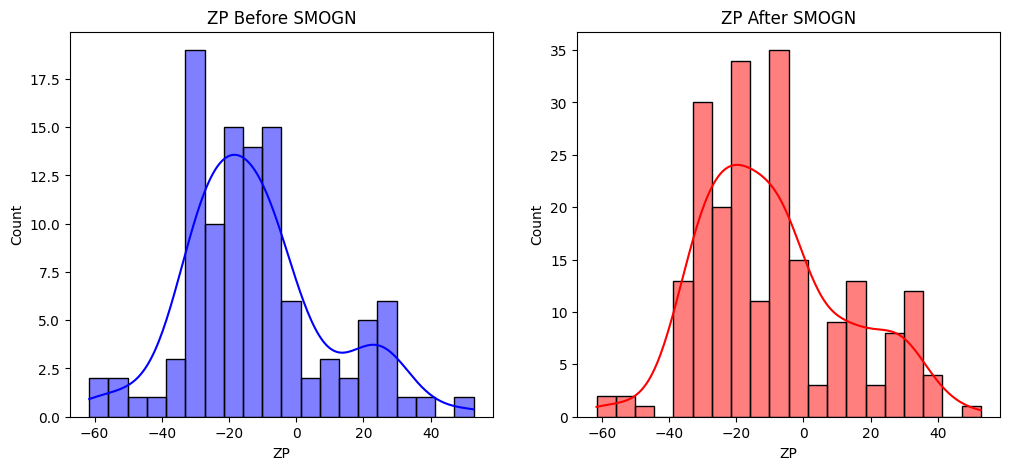

In [ ]:
plt.figure(figsize=(12, 5))

# Before SMOGN
plt.subplot(1, 2, 1)
sns.histplot(df_smogn_input["ZP"], bins=20, kde=True, color='blue')
plt.title("ZP Before SMOGN")

# After SMOGN
plt.subplot(1, 2, 2)
sns.histplot(df_smogn["ZP"], bins=20, kde=True, color='red')
plt.title("ZP After SMOGN")

plt.show()

Before SMOGN:
count    109.000000
mean      -1.745272
std       25.518195
min      -90.568818
25%      -13.269914
50%       -0.999495
75%        7.618683
max      100.000000
Name: CREA%, dtype: float64

After SMOGN:
count    216.000000
mean      20.064573
std       34.958453
min      -90.568818
25%       -1.281528
50%        8.512805
75%       40.235692
max      100.862110
Name: CREA%, dtype: float64


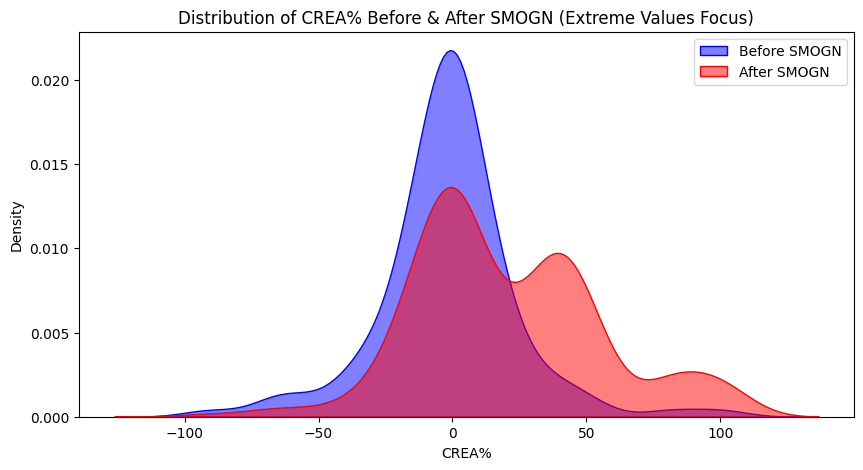

<ipython-input-45-e412be4ad628>:24: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[y_original, y_resampled], palette=["blue", "red"])


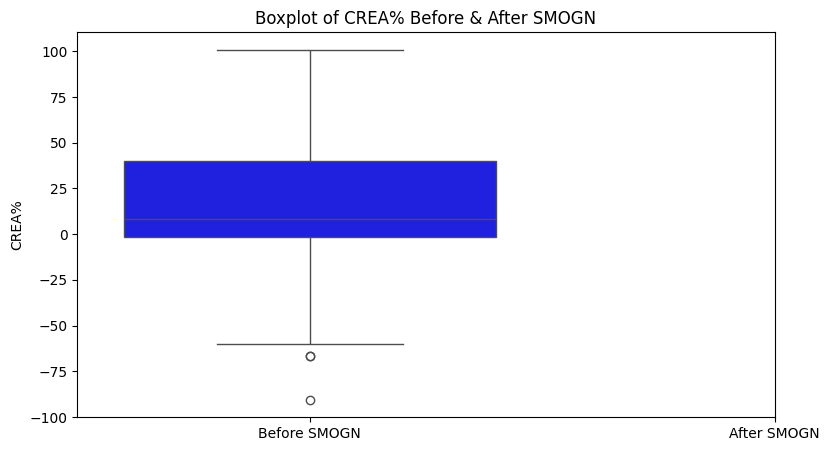

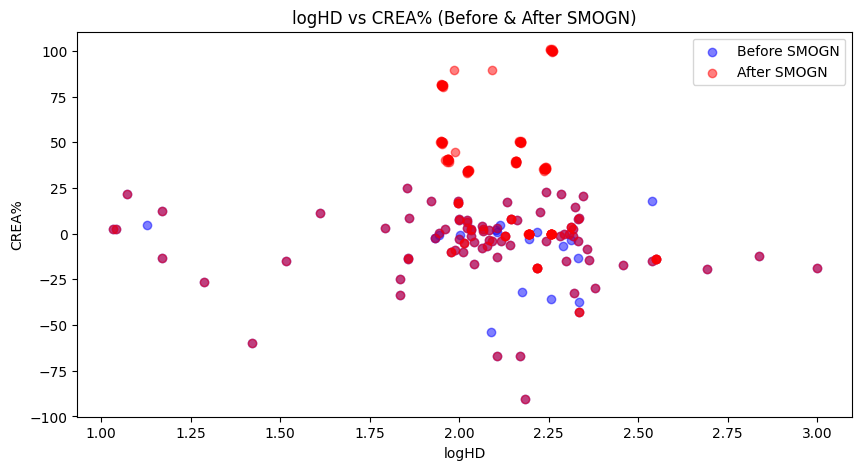

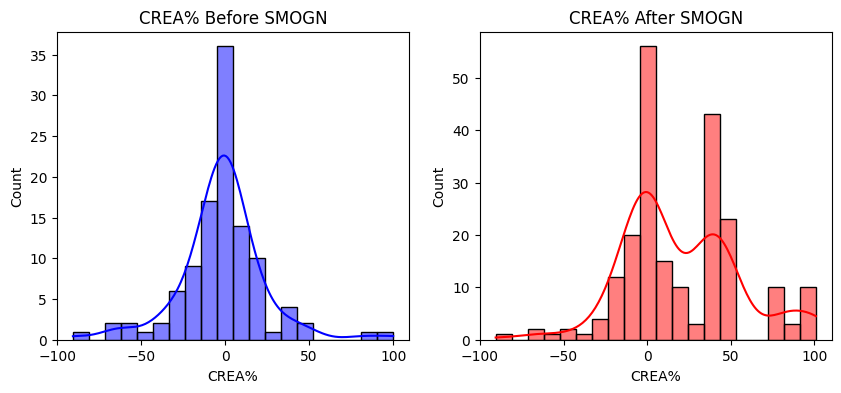

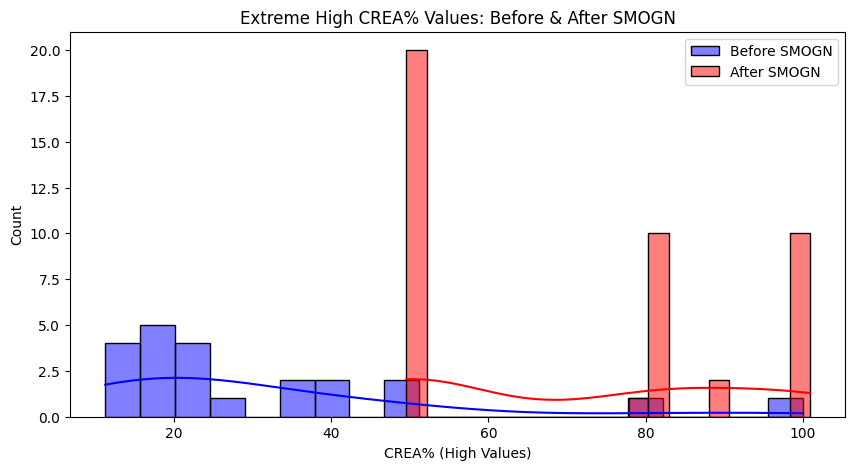

In [ ]:
#Examine the distributions before and after SMOGN
# ✅ Extract target variable
y_original = df_smogn_input["CREA%"]
y_resampled = df_smogn["CREA%"]

print("Before SMOGN:")
print(df_smogn_input["CREA%"].describe())

print("\nAfter SMOGN:")
print(df_smogn["CREA%"].describe())

# 🔹 **1. KDE Plot: Distribution of CREA% Before and After SMOGN**
plt.figure(figsize=(10, 5))
sns.kdeplot(y_original, label="Before SMOGN", fill=True, color='blue', alpha=0.5)
sns.kdeplot(y_resampled, label="After SMOGN", fill=True, color='red', alpha=0.5)
plt.title("Distribution of CREA% Before & After SMOGN (Extreme Values Focus)")
plt.xlabel("CREA%")
plt.ylabel("Density")
plt.legend()
plt.show()

# 🔹 **2. Box Plot: Checking Changes in Extreme CREA% Values**
plt.figure(figsize=(9, 5))
sns.boxplot(data=[y_original, y_resampled], palette=["blue", "red"])
plt.xticks([0, 1], ["Before SMOGN", "After SMOGN"])
plt.title("Boxplot of CREA% Before & After SMOGN")
plt.ylabel("CREA%")
plt.show()

# 🔹 **3. Scatter Plot: Feature vs CREA%**
plt.figure(figsize=(10, 5))
plt.scatter(df_smogn_input.iloc[:, 0], y_original, color='blue', alpha=0.5, label="Before SMOGN")
plt.scatter(df_smogn.iloc[:, 0], y_resampled, color='red', alpha=0.5, label="After SMOGN")
plt.xlabel(df_smogn_input.columns[0])  # Use first feature for visualization
plt.ylabel("CREA%")
plt.title(f"{df_smogn_input.columns[0]} vs CREA% (Before & After SMOGN)")
plt.legend()
plt.show()

# 🔹 **4. Histogram: Value Counts Before & After**
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_original, bins=20, kde=True, color='blue')
plt.title("CREA% Before SMOGN")

plt.subplot(1, 2, 2)
sns.histplot(y_resampled, bins=20, kde=True, color='red')
plt.title("CREA% After SMOGN")

plt.show()

# 🔹 **5. Zoom In: Focus on High CREA% (Above 80th Percentile)**
plt.figure(figsize=(10, 5))
sns.histplot(y_original[y_original > np.percentile(y_original, 80)], bins=20, kde=True, color='blue', label="Before SMOGN")
sns.histplot(y_resampled[y_resampled > np.percentile(y_resampled, 80)], bins=20, kde=True, color='red', label="After SMOGN")
plt.title("Extreme High CREA% Values: Before & After SMOGN")
plt.xlabel("CREA% (High Values)")
plt.legend()
plt.show()

In [ ]:
#Save SMOGN dataset
df_smogn.to_csv(os.path.join(root_dir + project_folder, "SMOGN dataset_CREA.csv"), index=False)

In [ ]:
df_smogn = pd.read_csv(os.path.join(root_dir + project_folder + "SMOGN dataset_CREA.csv"))

In [ ]:
df_smogn[['ZP' ,'CREA%']]

,ZP,CREA%
0,14.648738,0.000000
1,15.000000,0.000000
2,14.959847,0.000000
3,14.835249,0.000000
4,15.047621,0.000000
...,...,...
211,-17.700000,21.740321
212,-5.000000,-6.976744
213,-4.150000,-90.568818
214,-24.385475,50.000000


In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
#Read saved SMOGN data
df_smogn = pd.read_csv(os.path.join(root_dir + project_folder + "SMOGN dataset_CREA.csv"))

In [ ]:
df = df_smogn.copy()
df.shape

(216, 32)

In [ ]:
df.columns

Index(['logHD', 'ZP', 'AccumDose', 'PT_Inorganic', 'PT_Organic', 'MAT_Gold',
       'MAT_Hybrid', 'MAT_Inorganic others', 'MAT_Iron', 'MAT_Liposome',
       'MAT_Organic others', 'MAT_Polymeric', 'MAT_Silica', 'Shape_Plate',
       'Shape_Rod', 'Shape_Spherical', 'TS_Passive', 'TM_Allograft Orthotopic',
       'TM_Healthy', 'TM_Xenograft Heterotopic', 'TM_Xenograft Orthotopic',
       'Cancer_Freproductive', 'Cancer_GI tract', 'Cancer_Healthy',
       'Cancer_Lung', 'Cancer_Mreproductive', 'Cancer_Others', 'Cancer_Skin',
       'AT_YES', 'MM_healthy', 'CoDelivery_yes', 'CREA%'],
      dtype='object')

In [ ]:
X = df.drop(columns=["CREA%"])
y = df["CREA%"]

In [ ]:
X.shape

(216, 31)

In [ ]:
# Identify continuous and categorical features
continuous_features = ['ZP', "AccumDose"]  # Only ZP needs normalization

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])  # Keep original number of features
X_test[continuous_features] = scaler.transform(X_test[continuous_features])
X_scaled = np.vstack((X_train, X_test))

In [ ]:
X_train.shape

(172, 31)

In [ ]:
# Subset Train and Test Data Using Selected Features (optional)
X_train_selected = X_train
X_test_selected = X_test
X_scaled = np.vstack((X_train_selected, X_test_selected))

# **LightGBM regressor Model (the best model)**

## **Hyperparameter Tuning with Bayesian Optimization**

In [ ]:
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error as rmse
import numpy as np

In [ ]:
models_to_run = [LGBMRegressor(objective='regression', random_state=42)]
model_param_search = [{
    'num_leaves': Integer(10, 30),               # smaller range for better generalization
    'max_depth': Integer(3, 50),
    'learning_rate': Real(0.01, 0.05, prior='log-uniform'),  # slightly higher to reduce training rounds
    'n_estimators': Integer(100, 700),           # based on early stopping ~120
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.7, 1.0),
    'colsample_bytree': Real(0.7, 1.0),
    'reg_alpha': Real(0.0, 30.0),
    'reg_lambda': Real(0.0, 5.0)
}]

## **Model Training and Evaluation**

In [ ]:
# ✅ Define KFold Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=77)

#Store all CV results
cv_results = []

# ✅ Run Bayesian Search for LightGBM Model
print(f"\nRunning Bayesian Search for LightGBM Model...")

fit_params = {
    "eval_set": [(X_test_selected, y_test)],
    "eval_metric": "r2",
    "early_stopping_rounds": 50,
    "verbose": 0
}

bs = BayesSearchCV(
    estimator=models_to_run[0],
    search_spaces=model_param_search[0],
    cv=cv,
    n_iter=80,
    n_jobs=-1,
    scoring="r2",
    return_train_score=True,
    random_state=42
    )

# ✅ Fit the model
bs.fit(X_train_selected, y_train)

# ✅ Extract the best model
lgbm_model = bs.best_estimator_
test_preds = lgbm_model.predict(X_test_selected)
train_preds = lgbm_model.predict(X_train_selected)
all_preds = lgbm_model.predict(X_scaled)
y_obs = y

# ✅ Cross-validation scores
r2_kfolds = cross_val_score(lgbm_model, X_train_selected, y_train, cv=cv, n_jobs=-1, scoring='r2')
rmse_kfolds = cross_val_score(lgbm_model, X_train_selected, y_train, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

# ✅ Overall R2 for combined train and test
r2_all = r2_score(np.hstack([y_train, y_test]), np.hstack([train_preds, test_preds]))

# ✅ Print metrics
print('\nThe 5-CV RMSE Score was:', -rmse_kfolds.mean())
print('With a standard deviation of:', rmse_kfolds.std())
print('Test RMSE Score: %.2f' % rmse(y_test, test_preds))

print('\nThe 5-CV R2 Score was:', r2_kfolds.mean())
print('With a standard deviation of:', r2_kfolds.std())
print("Test R2 Score : %.2f" % r2_score(y_test, test_preds))
print("Train R2 Score : %.2f" % r2_score(y_train, train_preds))
print("All R2 Score : %.2f" % r2_all)
print("Train RMSE Score: %.2f" % rmse(y_train, train_preds))


Running Bayesian Search for LightGBM Model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 16
[LightGBM] [Info] Start training from score 19.821356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [ ]:
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_selected), 1):
    X_tr, X_te = X_train_selected.iloc[train_idx], X_train_selected.iloc[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    lgbm_model.fit(X_tr, y_tr)
    y_pred = lgbm_model.predict(X_te)

    for true_val, pred_val in zip(y_te, y_pred):
        cv_results.append({
            "Model": 'LightGBM',
            "Fold": fold,
            "True": true_val,
            "Predicted": pred_val,
            "Residual": true_val - pred_val
            })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.to_csv("LightGBM_cv_fold_predictions_model_comparison_CREA.csv", index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 15
[LightGBM] [Info] Start training from score 18.881501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
# extract best model and best hyperparameters
lgbm_model = bs.best_estimator_
lgbm_best_params = bs.best_params_

print("\n✅ Best Model:", lgbm_model)
print("\n✅ Best Hyperparameters:")
for param, value in lgbm_best_params.items():
    print(f"{param}: {value}")


✅ Best Model: LGBMRegressor(colsample_bytree=0.7, learning_rate=0.049999999999999996,
              max_depth=24, min_child_samples=13, n_estimators=451,
              num_leaves=24, objective='regression', random_state=42,
              reg_lambda=1.1816838057135557)

✅ Best Hyperparameters:
colsample_bytree: 0.7
learning_rate: 0.049999999999999996
max_depth: 24
min_child_samples: 13
n_estimators: 451
num_leaves: 24
reg_alpha: 0.0
reg_lambda: 1.1816838057135557
subsample: 1.0


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 19.821356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


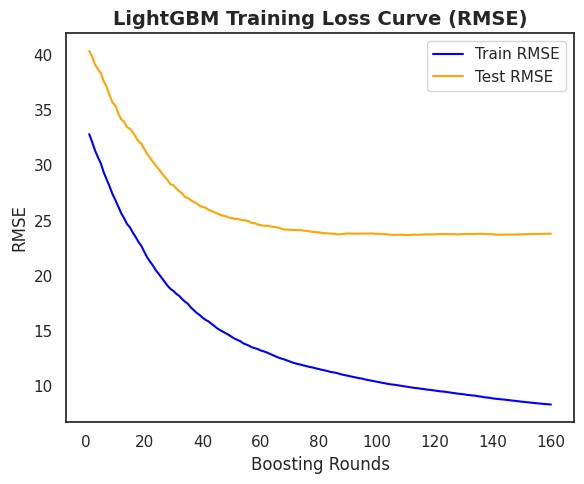

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# ✅ Recreate the best model manually
lgbm_model = lgb.LGBMRegressor(objective='regression', random_state=42, **lgbm_best_params)

# ✅ Dictionary to store evaluation results
eval_results = {}

# ✅ Fit the model and record evaluation metrics
lgbm_model.fit(
    X_train_selected,
    y_train,
    eval_set=[(X_train_selected, y_train), (X_test_selected, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50),
          lgb.record_evaluation(eval_results)]
)

# ✅ Extract RMSE values for plotting
train_rmse = eval_results['training']['rmse']
valid_rmse = eval_results['valid_1']['rmse']
rounds = range(1, len(train_rmse) + 1)

# ✅ Plot the RMSE loss curve
plt.figure(figsize=(6, 5))
plt.plot(rounds, train_rmse, label='Train RMSE', color='blue')
plt.plot(rounds, valid_rmse, label='Test RMSE', color='orange')
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("LightGBM Training Loss Curve (RMSE)", fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.savefig("LightGBM_Training Loss Curve_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)
plt.show()


In [ ]:
# Define save path
save_path = os.path.join(root_dir + project_folder, "lightGBM_bayes_model_CREA.joblib")

# Save the best estimator
joblib.dump(lgbm_model, save_path)
print(f"Best model saved at: {save_path}")

Best model saved at: /content/drive/My Drive/Colab Notebooks/SOT-nano-2025/lightGBM_bayes_model_CREA.joblib


In [ ]:
metrics_path = os.path.join(root_dir + project_folder,"lightGBM_metrics_CREA.txt")
with open(metrics_path, "w") as f:
    f.write(f"5-CV RMSE Score: {rmse_kfolds.mean():.4f}\n")
    f.write(f"Standard Deviation of RMSE: {rmse_kfolds.std():.4f}\n")
    f.write(f"Test RMSE Score: {rmse(y_test, test_preds):.4f}\n")
    f.write(f"5-CV R² Score: {r2_kfolds.mean():.4f}\n")
    f.write(f"Standard Deviation of R²: {r2_kfolds.std():.4f}\n")
    f.write(f"Test R² Score: {r2_score(y_test, test_preds):.4f}\n")
    f.write(f"Train R² Score: {r2_score(y_train, train_preds):.4f}\n")
    f.write(f"Overall R² Score: {r2_all:.4f}\n")
    f.write(f"Train RMSE Score: {rmse(y_train, train_preds):.4f}\n")


In [ ]:
# Save prediction on train and test data
# Create a DataFrame with actual and predicted values
predictions_df = pd.DataFrame({
    "Actual": np.hstack([y_train, y_test]),  # Combine train and test actual values
    "Predicted": np.hstack([train_preds, test_preds]),  # Combine predictions
    "Dataset": ["Train"] * len(y_train) + ["Test"] * len(y_test)  # Label data points
})

# Save to CSV
predictions_df.to_csv(os.path.join(root_dir + project_folder,"lightGBM_predictions_CREA.csv"), index=False)

print("Predictions saved to 'lightGBM_predictions_CREA.csv'")

Predictions saved to 'lightGBM_predictions_CREA.csv'


## **Model Evaluation Plots_LightGBM**

In [ ]:
import joblib
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error as rmse
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from shap._explanation import group_features

In [ ]:
# Define model path
model_path = os.path.join(root_dir + project_folder, "lightGBM_bayes_model_CREA.joblib")

# Load the trained model
lgbm_model = joblib.load(model_path)

In [ ]:
# Extract the model parameters
best_params = lgbm_model.get_params()

In [ ]:
# Define file path
predictions_path = os.path.join(root_dir + project_folder, "lightGBM_predictions_CREA.csv")

# Load the predictions DataFrame
predictions_df = pd.read_csv(predictions_path)

# Extract Train Data
y_train = predictions_df.loc[predictions_df["Dataset"] == "Train", "Actual"].values
train_preds = predictions_df.loc[predictions_df["Dataset"] == "Train", "Predicted"].values

# Extract Test Data
y_test = predictions_df.loc[predictions_df["Dataset"] == "Test", "Actual"].values
test_preds = predictions_df.loc[predictions_df["Dataset"] == "Test", "Predicted"].values

# Print confirmation
print(f" y_train size: {len(y_train)}, train_preds size: {len(train_preds)}")
print(f" y_test size: {len(y_test)}, test_preds size: {len(test_preds)}")

 y_train size: 172, train_preds size: 172
 y_test size: 44, test_preds size: 44


In [ ]:
#loading cv_results_df
cv_results_df = pd.read_csv("LightGBM_cv_fold_predictions_model_comparison_CREA.csv")

In [ ]:
r2_test = r2_score(y_test, test_preds)  # Test R²
r2_train = r2_score(y_train, train_preds)  # Train R²
r2_all = r2_score(np.concatenate([y_train, y_test]), np.concatenate([train_preds, test_preds]))  # All Data R²

rmse_test = rmse(y_test, test_preds)  # Test RMSE
rmse_train = rmse(y_train, train_preds)  # Train RMSE

In [ ]:
from sklearn.metrics import auc

fold_aucs = []

for fold_num, fold_df in cv_results_df.groupby("Fold"):
    # Sort by predicted values (descending)
    fold_sorted = fold_df.sort_values(by="Predicted", ascending=False).reset_index(drop=True)

    # Cumulative gain
    fold_sorted["CumulativeTrue"] = fold_sorted["True"].cumsum()
    fold_sorted["SamplePercent"] = np.linspace(0, 1, len(fold_sorted))
    fold_sorted["GainPercent"] = fold_sorted["CumulativeTrue"] / fold_sorted["True"].sum()

    # AUC under gain curve
    gain_auc = auc(fold_sorted["SamplePercent"], fold_sorted["GainPercent"])
    fold_aucs.append((fold_num, gain_auc))

# Display AUCs
for fold_num, score in fold_aucs:
    print(f"Fold {fold_num}: Gain AUC = {score:.4f}")

# Mean AUC across folds
mean_gain_auc = np.mean([x[1] for x in fold_aucs])
print(f"\nMean Gain AUC across folds: {mean_gain_auc:.4f}")

Fold 1: Gain AUC = 0.8806
Fold 2: Gain AUC = 0.9606
Fold 3: Gain AUC = 0.9664
Fold 4: Gain AUC = 0.9321
Fold 5: Gain AUC = 0.9126

Mean Gain AUC across folds: 0.9305


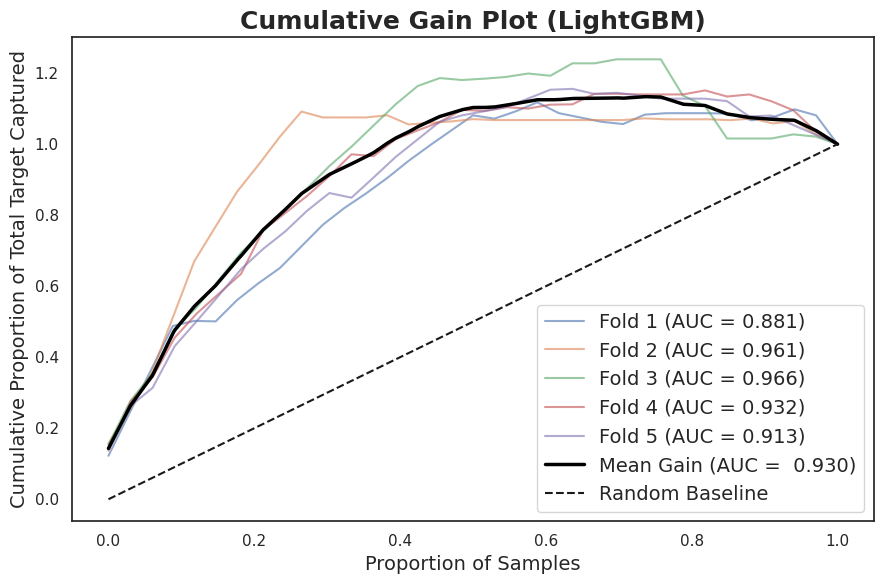

In [ ]:
# Parameters
n_points = 1000  # Number of interpolation points for consistency

# Prepare storage for interpolated gains
interpolated_gains = []
x_common = np.linspace(0, 1, n_points)
# Initialize plot
plt.figure(figsize=(9,6))

# Process each fold
for fold_num, gain_auc in fold_aucs:
    fold_df = cv_results_df[cv_results_df["Fold"] == fold_num]
    fold_sorted = fold_df.sort_values(by="Predicted", ascending=False).reset_index(drop=True)
    fold_sorted["CumulativeTrue"] = fold_sorted["True"].cumsum()
    fold_sorted["SamplePercent"] = np.linspace(0, 1, len(fold_sorted))
    fold_sorted["GainPercent"] = fold_sorted["CumulativeTrue"] / fold_sorted["True"].sum()

    # Interpolate for averaging
    interp_gain = np.interp(x_common, fold_sorted["SamplePercent"], fold_sorted["GainPercent"])
    interpolated_gains.append(interp_gain)

    # Plot each fold
    plt.plot(fold_sorted["SamplePercent"], fold_sorted["GainPercent"], alpha=0.6,
             label=f"Fold {fold_num} (AUC = {gain_auc:.3f})")

# Compute mean and (optional) bounds
interpolated_gains = np.array(interpolated_gains)
mean_gain = interpolated_gains.mean(axis=0)
min_gain = interpolated_gains.min(axis=0)
max_gain = interpolated_gains.max(axis=0)

# Plot mean curve
x_common = np.linspace(0, 1, n_points)
plt.plot(x_common, mean_gain, color='black', linewidth=2.5, label=f"Mean Gain (AUC = {mean_gain_auc: .3f})")

# Baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

# Final plot settings
plt.title("Cumulative Gain Plot (LightGBM)", fontsize=18, fontweight='bold')
plt.xlabel("Proportion of Samples", fontsize=14)
plt.ylabel("Cumulative Proportion of Total Target Captured", fontsize=14)
plt.legend(loc='lower right', fontsize=14, frameon=True)
plt.tight_layout()
plt.savefig("LightGBM_cumulative gain plot_test set_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

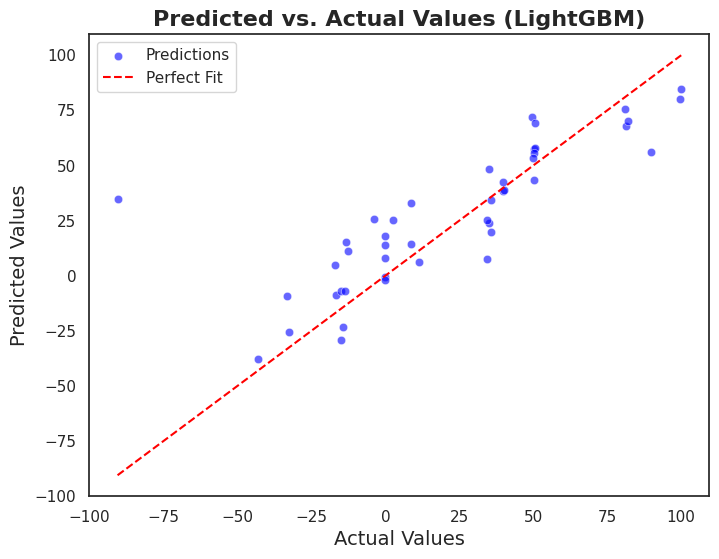

In [ ]:
# ✅ Generate Evaluation Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6, color="blue", label="Predictions")

# ✅ Add Perfect Fit Line (Diagonal)
min_val = min(y_test.min(), test_preds.min())
max_val = max(y_test.max(), test_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color="red", label="Perfect Fit")

plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs. Actual Values (LightGBM)", fontsize=16, fontweight="bold")
plt.legend()

#save this figure as tiff format
plt.savefig("LightGBM_Scatterplot of R score for the test set_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

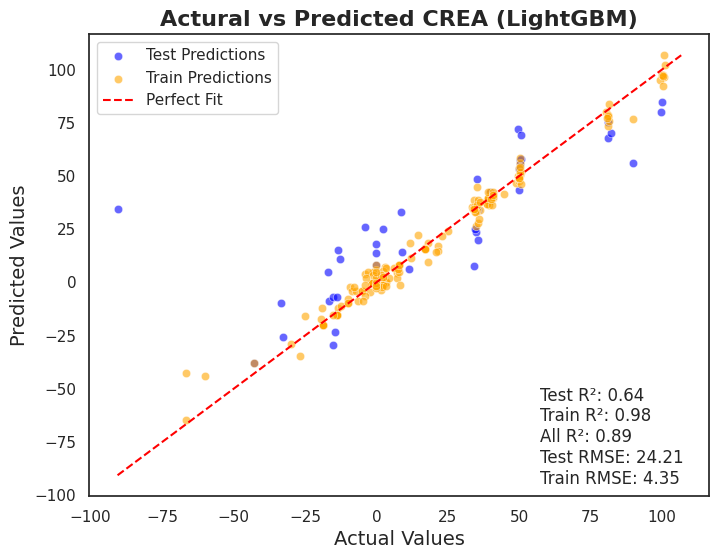

In [ ]:
3 # ✅ Generate Scatter Plot for Train & Test Data
plt.figure(figsize=(8, 6))

# 🔹 Test Data (Blue)
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6, color="blue", label="Test Predictions")

# 🔹 Training Data (Orange)
sns.scatterplot(x=y_train, y=train_preds, alpha=0.6, color="orange", label="Train Predictions")

# 🔹 Perfect Fit Line (Red Dashed)
min_val = min(y_test.min(), test_preds.min(), y_train.min(), train_preds.min())
max_val = max(y_test.max(), test_preds.max(), y_train.max(), train_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color="red", label="Perfect Fit")

# 🔹 Add R² and RMSE Labels at the Bottom Right Corner
text_x = max_val - 0.25 * (max_val - min_val)  # Position slightly left
text_y = min_val - 0.02 * (max_val - min_val)  # Position slightly above the bottom
plt.text(text_x, text_y,
     f"Test R²: {r2_test:.2f}\n"
     f"Train R²: {r2_train:.2f}\n"
     f"All R²: {r2_all:.2f}\n"
     f"Test RMSE: {rmse_test:.2f}\n"
     f"Train RMSE: {rmse_train:.2f}",
     fontsize=12)

# 🔹 Formatting
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Actural vs Predicted CREA (LightGBM)", fontsize=16, fontweight="bold")
plt.legend()
plt.grid(False)

#save this figure as tiff format
plt.savefig("LightGBM_Scatterplot of R score for the full dataset_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

In [ ]:
import shap

# Initialize SHAP Explainer with the Best Model
explainer = shap.Explainer(lgbm_model, X_train_selected)

X_test_selected = X_test_selected[X_train_selected.columns]

# Compute SHAP Values for test set
shap_values = explainer(X_test_selected, check_additivity=False)
shap_importance = np.abs(shap_values.values).mean(axis=0)

feature_map = {
    col: col.split("_")[0] if "_" in col else col
    for col in shap_values.feature_names
}
grouped_shap = group_features(shap_values, feature_map)

# Calculate shap_feature_order before using it
shap_feature_order = np.array(grouped_shap.feature_names)[np.argsort(np.abs(grouped_shap.values).mean(0))][::-1]

feature_importance_df = pd.DataFrame({
    "Feature": grouped_shap.feature_names,
    "Mean SHAP": np.abs(grouped_shap.values).mean(axis=0)
})

feature_importance_df = (
    feature_importance_df.set_index("Feature")
    .loc[shap_feature_order]
    .reset_index()
)

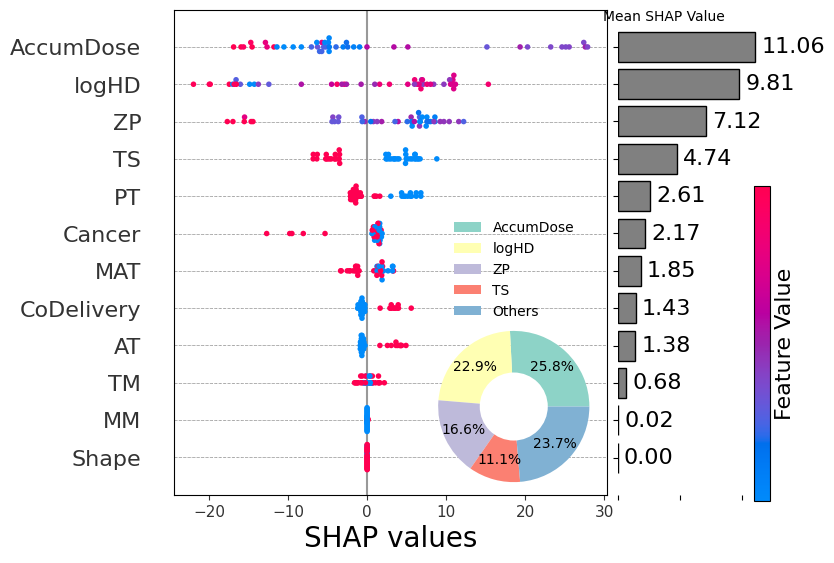

In [ ]:
from matplotlib import gridspec

# ✅ Create Figure Layout (SHAP on Left, Feature Importance in Middle, Color Bar on Right)
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 0.9])  # SHAP summary and Barplot

# ✅ Generate SHAP Summary Plot (Left Side)
ax_shap = fig.add_subplot(gs[0])
shap.plots.beeswarm(grouped_shap, max_display=shap_values.shape[1], show=False, color_bar=False)
#ax_shap.set_xlim(-50, 60)
ax_shap.set_xlabel("SHAP values", fontsize=20)
current_ax = plt.gca()
fig.axes[0] = current_ax

# ✅ Keep the plot border of the SHAP summary plot
ax_shap.spines["top"].set_visible(True)
ax_shap.spines["right"].set_visible(True)
ax_shap.spines["left"].set_visible(True)
ax_shap.spines["bottom"].set_visible(True)

ax_shap.grid(True, axis = "y", linestyle = "--", linewidth = 0.6, color = "gray", alpha = 0.7)

ax_shap.tick_params(axis='y', labelsize=16)

# ✅ Extract Feature Order from SHAP Summary Plot
shap_feature_order = np.array(grouped_shap.feature_names)[np.argsort(np.abs(grouped_shap.values).mean(0))][::-1]

# ✅ Generate Mean SHAP Values as a Bar Chart
ax_bar = fig.add_axes([0.68, 0.11, 0.18, 0.77])
bars = ax_bar.barh(feature_importance_df["Feature"], feature_importance_df["Mean SHAP"], color="gray", edgecolor = "black")

for bar in bars:
    width = bar.get_width()  # Get bar length (SHAP value)
    ax_bar.text(
        width + 0.5,  # Small offset to the right
        bar.get_y() + bar.get_height()/2,  # Center text vertically
        f"{width:.2f}",  # Format value with 3 decimal places
        ha='left', va='center', fontsize=16, color="black"
    )

# ✅ Move X-Axis Title Manually (Adjusted for Visibility)
ax_bar.set_xlabel("Mean SHAP Value", labelpad=16)
ax_bar.xaxis.set_label_coords(0.32, 1)  # Fine-tuned placement

# ✅ Remove X-axis labels
ax_bar.set_xticklabels([])  # Remove x-axis labels
ax_bar.invert_yaxis()  # Ensure the order matches the SHAP summary plot
ax_bar.set_yticklabels([])  # Remove feature names from Y-axis

# ✅ Remove the border (spines) of the bar plot
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)
ax_bar.spines["left"].set_visible(False)
ax_bar.spines["bottom"].set_visible(False)

# ✅ Manually Add the Color Bar (Optimized Position)
ax_colorbar = fig.add_axes([0.85, 0.1, 0.02, 0.5])  # [left, bottom, width, height]
shap_colormap = shap.plots.colors.red_blue
sm = plt.cm.ScalarMappable(cmap=shap_colormap)  # Define SHAP color map
cbar = plt.colorbar(sm, cax=ax_colorbar, orientation="vertical")
cbar.set_label("Feature Value", fontsize=16)

# ✅ Remove Y-Axis Labels and Ticks from Color Bar
cbar.ax.set_yticklabels([])  #  Remove tick labels
cbar.ax.yaxis.set_ticks([])  #  Remove ticks

# ✅ Remove the Border from the Color Bar
cbar.ax.spines["top"].set_visible(False)
cbar.ax.spines["right"].set_visible(False)
cbar.ax.spines["left"].set_visible(False)
cbar.ax.spines["bottom"].set_visible(False)

# ✅ Manually Add the Donut Chart (Optimized Positioning)
ax_donut = fig.add_axes([0.4, 0.1, 0.3, 0.3])  # Adjusted position for better balance

# ✅ Define Feature Contributions
feature_contributions = feature_importance_df["Mean SHAP"] / feature_importance_df["Mean SHAP"].sum() * 100
top_features = feature_contributions[:4].sum()
other_features = 100 - top_features

# Define readable labels
custom_label_map = {
    "logHD": "logHD",
    "ZP": "ZP"
}
sizes = list(feature_contributions[:4]) + [other_features]
original_labels = list(feature_importance_df["Feature"][:4]) + ["Others"]
labels = [custom_label_map.get(label, label) for label in original_labels]
colors = sns.color_palette("Set3", len(sizes))


# ✅ Create the Donut Chart
wedges, texts, autotexts = ax_donut.pie(
    sizes,
    autopct='%1.1f%%',  # Display percentage values
    pctdistance=0.73,  # Moves percentage labels outward slightly
    colors=colors
)

# ✅ Adjust font size for better visibility
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color("black")

# ✅ Add a White Circle at the Center to Maintain Donut Shape
center_circle = plt.Circle((0, 0), 0.45, fc='white')
ax_donut.add_artist(center_circle)

# ✅ Add a Legend Directly Above the Donut Chart
ax_donut.legend(
    handles=wedges, labels=labels, loc="lower center", bbox_to_anchor=(0.5, 0.9),
    fontsize=10, ncol=1, frameon=False, alignment="right")

plt.show()

In [ ]:
fig.set_size_inches(10, 8)
fig.savefig("LGBM_Shap feature importance for test set of CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

In [ ]:
#SHAP analysis for the full dataset

# Initialize Explainer with Training Data (No Scaling in This Case)
explainer = shap.Explainer(lgbm_model, X_train_selected)

# Ensure Features are the Same and in the Same Order
X_full = X_full = pd.concat([X_train_selected, X_test_selected]).reset_index(drop=True)

# Disable Additivity Check (If Necessary)
shap_values_full = explainer(X_full, check_additivity=False)  # Disable additivity check

# Proceed to Calculate SHAP Importance
shap_importance = np.abs(shap_values_full.values).mean(axis=0)

feature_map = {
    col: col.split("_")[0] if "_" in col else col
    for col in shap_values_full.feature_names
}
grouped_shap_full = group_features(shap_values_full, feature_map)

shap_feature_order = np.array(grouped_shap_full.feature_names)[
    np.argsort(np.abs(grouped_shap_full.values).mean(0))[::-1]
]
feature_importance_df = pd.DataFrame({
    "Feature": grouped_shap_full.feature_names,
    "Mean SHAP": np.abs(grouped_shap_full.values).mean(axis=0)
})

feature_importance_df = (
    feature_importance_df.set_index("Feature")
    .loc[shap_feature_order]
    .reset_index()
)

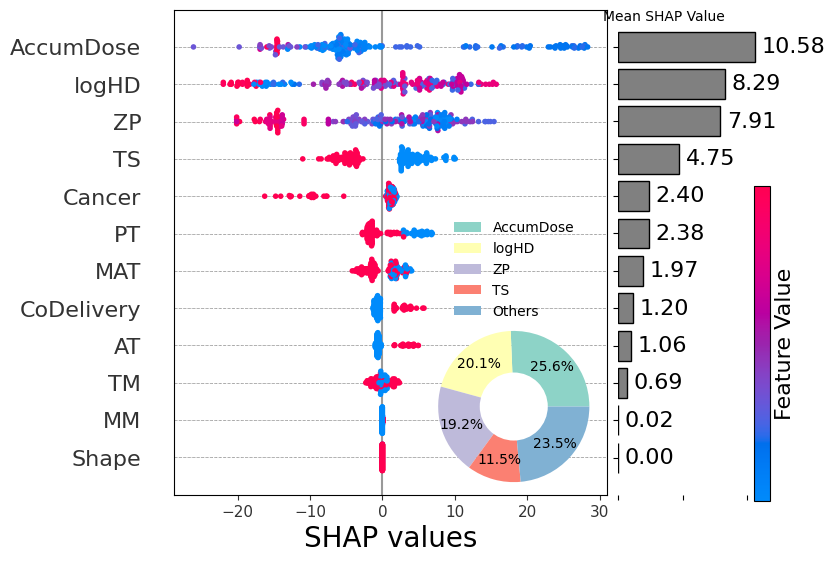

In [ ]:
from matplotlib import gridspec

# ✅ Create Figure Layout (SHAP on Left, Feature Importance in Middle, Color Bar on Right)
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 0.9])  # SHAP summary and Barplot

# ✅ Generate SHAP Summary Plot (Left Side)
ax_shap = fig.add_subplot(gs[0])
shap.plots.beeswarm(grouped_shap_full, max_display=shap_values_full.shape[1], show=False, color_bar=False)
ax_shap.set_xlabel("SHAP values", fontsize=20)
current_ax = plt.gca()
fig.axes[0] = current_ax

# ✅ Keep the plot border of the SHAP summary plot
ax_shap.spines["top"].set_visible(True)
ax_shap.spines["right"].set_visible(True)
ax_shap.spines["left"].set_visible(True)
ax_shap.spines["bottom"].set_visible(True)

ax_shap.grid(True, axis = "y", linestyle = "--", linewidth = 0.6, color = "gray", alpha = 0.7)

ax_shap.tick_params(axis='y', labelsize=16)

# ✅ Extract Feature Order from SHAP Summary Plot
shap_feature_order = np.array(grouped_shap_full.feature_names)[np.argsort(np.abs(grouped_shap_full.values).mean(0))][::-1]

# ✅ Generate Mean SHAP Values as a Bar Chart
ax_bar = fig.add_axes([0.68, 0.11, 0.18, 0.77])
bars = ax_bar.barh(feature_importance_df["Feature"], feature_importance_df["Mean SHAP"], color="gray", edgecolor = "black")

for bar in bars:
    width = bar.get_width()  # Get bar length (SHAP value)
    ax_bar.text(
        width + 0.5,  # Small offset to the right
        bar.get_y() + bar.get_height()/2,  # Center text vertically
        f"{width:.2f}",  # Format value with 3 decimal places
        ha='left', va='center', fontsize=16, color="black"
    )

# ✅ Move X-Axis Title Manually (Adjusted for Visibility)
ax_bar.set_xlabel("Mean SHAP Value", labelpad=16)
ax_bar.xaxis.set_label_coords(0.32, 1)  # Fine-tuned placement

# ✅ Remove X-axis labels
ax_bar.set_xticklabels([])  # Remove x-axis labels
ax_bar.invert_yaxis()  # Ensure the order matches the SHAP summary plot
ax_bar.set_yticklabels([])  # Remove feature names from Y-axis

# ✅ Remove the border (spines) of the bar plot
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)
ax_bar.spines["left"].set_visible(False)
ax_bar.spines["bottom"].set_visible(False)

# ✅ Manually Add the Color Bar (Optimized Position)
ax_colorbar = fig.add_axes([0.85, 0.1, 0.02, 0.5])  # [left, bottom, width, height]
shap_colormap = shap.plots.colors.red_blue
sm = plt.cm.ScalarMappable(cmap=shap_colormap)  # Define SHAP color map
cbar = plt.colorbar(sm, cax=ax_colorbar, orientation="vertical")
cbar.set_label("Feature Value", fontsize=16)

# ✅ Remove Y-Axis Labels and Ticks from Color Bar
cbar.ax.set_yticklabels([])  #  Remove tick labels
cbar.ax.yaxis.set_ticks([])  #  Remove ticks

# ✅ Remove the Border from the Color Bar
cbar.ax.spines["top"].set_visible(False)
cbar.ax.spines["right"].set_visible(False)
cbar.ax.spines["left"].set_visible(False)
cbar.ax.spines["bottom"].set_visible(False)

# ✅ Manually Add the Donut Chart (Optimized Positioning)
ax_donut = fig.add_axes([0.4, 0.1, 0.3, 0.3])  # Adjusted position for better balance

# ✅ Define Feature Contributions
feature_contributions = feature_importance_df["Mean SHAP"] / feature_importance_df["Mean SHAP"].sum() * 100
top_features = feature_contributions[:4].sum()
other_features = 100 - top_features

# Define readable labels
custom_label_map = {
    "logHD": "logHD",
    "ZP": "ZP"
}
sizes = list(feature_contributions[:4]) + [other_features]
original_labels = list(feature_importance_df["Feature"][:4]) + ["Others"]
labels = [custom_label_map.get(label, label) for label in original_labels]
colors = sns.color_palette("Set3", len(sizes))


# ✅ Create the Donut Chart
wedges, texts, autotexts = ax_donut.pie(
    sizes,
    autopct='%1.1f%%',  # Display percentage values
    pctdistance=0.73,  # Moves percentage labels outward slightly
    colors=colors
)

# ✅ Adjust font size for better visibility
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color("black")

# ✅ Add a White Circle at the Center to Maintain Donut Shape
center_circle = plt.Circle((0, 0), 0.45, fc='white')
ax_donut.add_artist(center_circle)

# ✅ Add a Legend Directly Above the Donut Chart
ax_donut.legend(
    handles=wedges, labels=labels, loc="lower center", bbox_to_anchor=(0.5, 0.9),
    fontsize=10, ncol=1, frameon=False, alignment="right")

plt.show()

In [ ]:
fig.set_size_inches(10, 8)
fig.savefig("LGBM_Shap feature importance for full dataset of CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

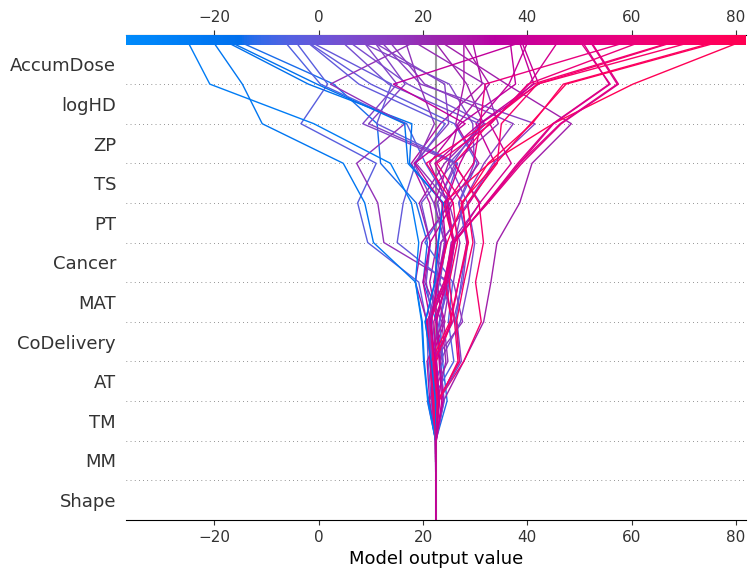

In [ ]:
# ✅ Ensure SHAP values are computed correctly
explainer = shap.Explainer(lgbm_model, X_train_selected)  # Ensure correct initialization
shap_values = explainer(X_test_selected, check_additivity=False)  # Compute SHAP values properly

# group the features
feature_map = {
    col: col.split("_")[0] if "_" in col else col
    for col in shap_values.feature_names
}
grouped_shap = group_features(shap_values, feature_map)

# ✅ Ensure SHAP JS visualization is enabled (for notebooks)
shap.initjs()

# ✅ Generate Decision Plot using Test Set
plt.figure(figsize=(10, 6))
shap.decision_plot(
    base_value=np.mean(grouped_shap.base_values),  # Extract base_values correctly
    shap_values=grouped_shap.values,  # SHAP values for test set
    features=grouped_shap.feature_names,  # Test set feature values
    feature_names=grouped_shap.feature_names,  # Feature names
    show=False
)
plt.savefig("LGBM_Shap Decision plot for test set_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)
# ✅ Show the plot
plt.show()


In [ ]:
# Create DataFrame with SHAP values and corresponding categorical feature values
shap_lgbm_df = pd.DataFrame(shap_values.values, columns=X_test_selected.columns)
shap_lgbm_df["MM_healthy"] = X_test_selected["MM_healthy"].values  # Add categorical feature (Mouse Model)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 2: Compute mean SHAP value per category
shap_by_category_mm = shap_lgbm_df.groupby("MM_healthy").mean().reset_index()

# Step 3: Use LabelEncoder to map numerical values back to original categories
label_encoder = LabelEncoder()

# Fit the LabelEncoder with the original categories
label_encoder.fit(["healthy", "tumor-bearing"])

# View the mapping between categories and numerical values
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", mapping)

# Decode numerical values back to original categories
shap_by_category_mm["MM_healthy"] = label_encoder.inverse_transform(shap_by_category_mm["MM_healthy"].astype(int))

# Interpret the Results
for index, row in shap_by_category_mm.iterrows():
    mm_category = row["MM_healthy"]
    mean_shap_value = row.drop("MM_healthy").mean()  # Compute mean SHAP value for the category
    if mean_shap_value > 0:
        print(f"{mm_category}: Mean SHAP Value = {mean_shap_value:.2f} (Increases AST%)")
    else:
        print(f"{mm_category}: Mean SHAP Value = {mean_shap_value:.2f} (Decreases AST%)")

Label Mapping: {np.str_('healthy'): np.int64(0), np.str_('tumor-bearing'): np.int64(1)}
healthy: Mean SHAP Value = 0.18 (Increases AST%)
tumor-bearing: Mean SHAP Value = -0.25 (Decreases AST%)


In [ ]:
#convert grouped_shap_full to a dataframe
shap_df_full = pd.DataFrame(grouped_shap_full.values, columns = grouped_shap_full.feature_names)

# Identify the one-hot encoded MAT columns
mat_cols = [col for col in X_full.columns if col.startswith('MAT_')]

# Label the MAT
materials_labels = X_full[mat_cols].idxmax(axis=1)
maberials_labels = materials_labels.str.replace("MAT_", "")

#Health conditions
condition_label = np.where(X_full['Cancer_Healthy'] == 1, "Healthy", "Tumor-bearing")

shap_mat_df = pd.DataFrame({
    "MAT": materials_labels,
    "Condition": condition_label,
    "SHAP_MAT": shap_df_full["MAT"]
})

MAT_df = shap_mat_df.groupby(["MAT", "Condition"])['SHAP_MAT'].mean().reset_index()
MAT_df["MAT"] = MAT_df["MAT"].str.replace("MAT_", "")

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

materials = shap_mat_df['MAT'].unique()
p_values = []

#Mann-Whitney U test
for mat in materials:
    group = shap_mat_df[shap_mat_df['MAT'] == mat]
    group_healthy = group[group['Condition'] == 'Healthy']['SHAP_MAT']
    group_tumor = group[group['Condition'] == 'Tumor-bearing']['SHAP_MAT']

    if len(group_healthy) > 1 and len(group_tumor) > 1:
        stat, p = mannwhitneyu(group_healthy, group_tumor, alternative='two-sided')
    else:
        p = np.nan  # not enough data
    p_values.append(p)

# Store results
pval_df = pd.DataFrame({
    'Material': materials,
    'p-value': p_values
})

# Apply multiple testing correction (FDR)
pvals_for_corr = pval_df['p-value'].dropna()
rej, adj_pvals, _, _ = multipletests(pvals_for_corr, method='fdr_bh')

# Fill into df
pval_df['adj_p'] = np.nan
pval_df.loc[pvals_for_corr.index, 'adj_p'] = adj_pvals

# Significance annotation
def label_sig(p):
    if pd.isna(p):
        return 'n/a'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

pval_df['Significance'] = pval_df['adj_p'].apply(label_sig)

# Sort and preview
pval_df = pval_df.sort_values('p-value')
print(pval_df)

               Material   p-value     adj_p Significance
1    MAT_Organic others  0.024242  0.065353           ns
3          MAT_Liposome  0.026141  0.065353           ns
0         MAT_Polymeric  0.192823  0.321372           ns
5            MAT_Silica  0.533333  0.666667           ns
2              MAT_Gold  0.791138  0.791138           ns
4  MAT_Inorganic others       NaN       NaN          n/a
6            MAT_Hybrid       NaN       NaN          n/a
7              MAT_Iron       NaN       NaN          n/a


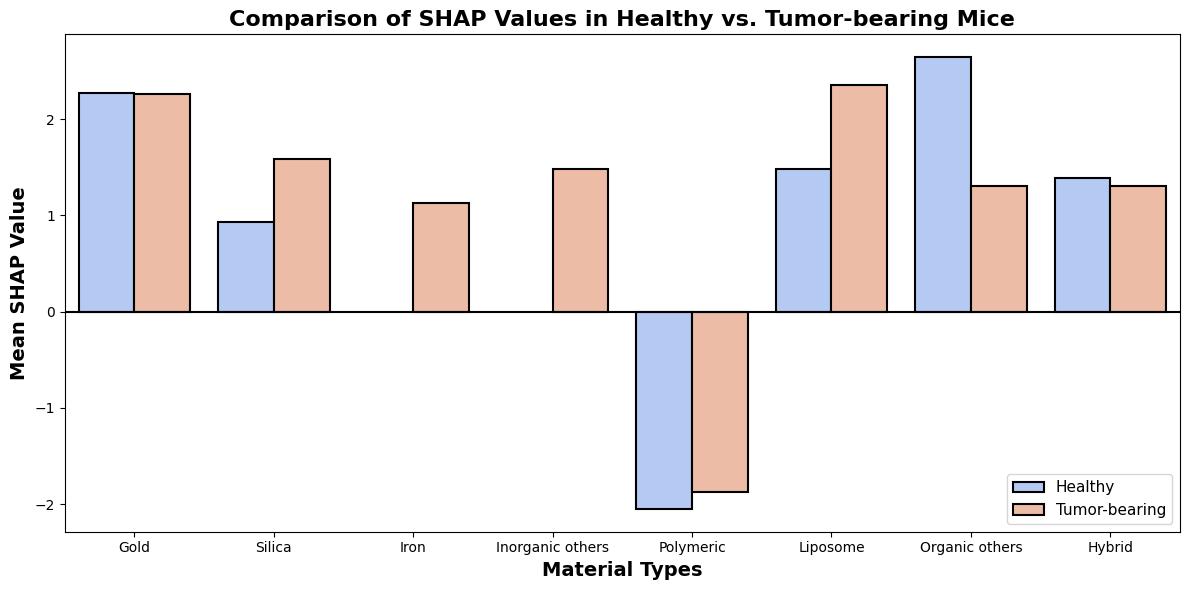

In [ ]:
# Create grouped barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data = MAT_df, x="MAT", y="SHAP_MAT", hue="Condition",
                 order = ["Gold", "Silica", "Iron", "Inorganic others", "Polymeric", "Liposome", "Organic others", "Hybrid"],
                 palette="coolwarm", edgecolor='black', linewidth=1.5)

# Add horizontal line at y=0
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

# Add labels and title
plt.xlabel("Material Types", fontsize=14, fontweight='bold')
plt.ylabel("Mean SHAP Value", fontsize=14, fontweight='bold')
plt.title("Comparison of SHAP Values in Healthy vs. Tumor-bearing Mice", fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.legend(loc='lower right',bbox_to_anchor=(1, 0),
    fontsize=11,
    frameon=True)
plt.savefig("LGBM_Comparison between SHAP values by different health model and materials for full dataset_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

In [ ]:
# Identify the one-hot encoded TS columns
PT_cols = ['PT_Inorganic', 'PT_Organic', 'MAT_Hybrid']

# Label the MAT
PT_labels = X_full[PT_cols].idxmax(axis=1)
PT_labels = PT_labels.str.replace("PT_", "")
PT_labels = PT_labels.str.replace("MAT_", "")

#Health conditions
condition_label = np.where(X_full['Cancer_Healthy'] == 1, "Healthy", "Tumor-bearing")

shap_pt_df = pd.DataFrame({
    "PT": PT_labels,
    "Condition": condition_label,
    "SHAP_PT": shap_df_full["PT"]
})

PT_df = shap_pt_df.groupby(["PT", "Condition"])['SHAP_PT'].mean().reset_index()

In [ ]:
PT = shap_pt_df['PT'].unique()
p_values = []

#Mann-Whitney U test
for pt in PT:
    group = shap_pt_df[shap_pt_df['PT'] == pt]
    group_healthy = group[group['Condition'] == 'Healthy']['SHAP_PT']
    group_tumor = group[group['Condition'] == 'Tumor-bearing']['SHAP_PT']

    if len(group_healthy) > 1 and len(group_tumor) > 1:
        stat, p = mannwhitneyu(group_healthy, group_tumor, alternative='two-sided')
    else:
        p = np.nan  # not enough data
    p_values.append(p)

# Store results
pval_df = pd.DataFrame({
    'PT': PT,
    'p-value': p_values
})

# Apply multiple testing correction (FDR)
pvals_for_corr = pval_df['p-value'].dropna()
rej, adj_pvals, _, _ = multipletests(pvals_for_corr, method='fdr_bh')

# Fill into df
pval_df['adj_p'] = np.nan
pval_df.loc[pvals_for_corr.index, 'adj_p'] = adj_pvals

# Significance annotation
def label_sig(p):
    if pd.isna(p):
        return 'n/a'
    elif p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

pval_df['Significance'] = pval_df['adj_p'].apply(label_sig)

# Sort and preview
pval_df = pval_df.sort_values('p-value')
print(pval_df)

          PT   p-value     adj_p Significance
1    Organic  0.312325  0.624650           ns
0  Inorganic  0.703158  0.703158           ns
2     Hybrid       NaN       NaN          n/a


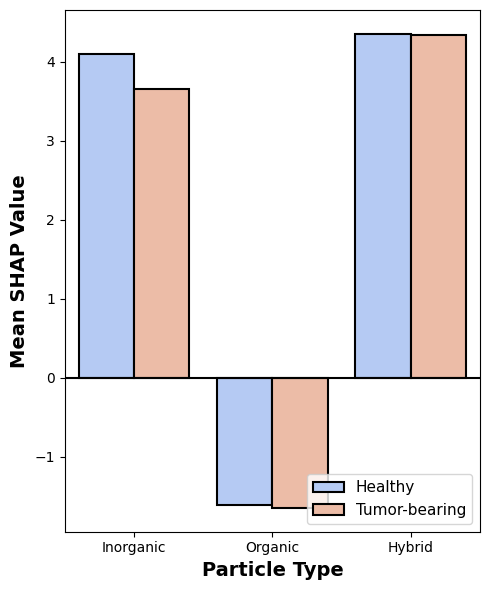

In [ ]:
# Create grouped barplot
plt.figure(figsize=(5, 6))
ax = sns.barplot(data=PT_df, x="PT", y="SHAP_PT", hue="Condition",
                 order = ["Inorganic", "Organic", "Hybrid"],
                 palette="coolwarm", edgecolor='black', linewidth=1.5)

# Add horizontal line at y=0
plt.axhline(0, color='black', linewidth=1.5, linestyle='-')

# Add labels and title
plt.xlabel("Particle Type", fontsize=14, fontweight='bold')
plt.ylabel("Mean SHAP Value", fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.legend(loc='lower right',
    fontsize=11,
    frameon=True)
plt.savefig("LGBM_Comparison between SHAP values by different health model and particle type for full dataset_CREA.tiff", dpi = 300, format = "tiff", bbox_inches = "tight", pad_inches = 0.1)

plt.show()

In [ ]:
scaler_zp = StandardScaler().fit(
    X_train_selected[['ZP']]
)
X_full['ZP_orig'] = X_full['ZP'] * scaler_zp.scale_[0] + scaler_zp.mean_[0]

In [ ]:
scaler_zp

StandardScaler()

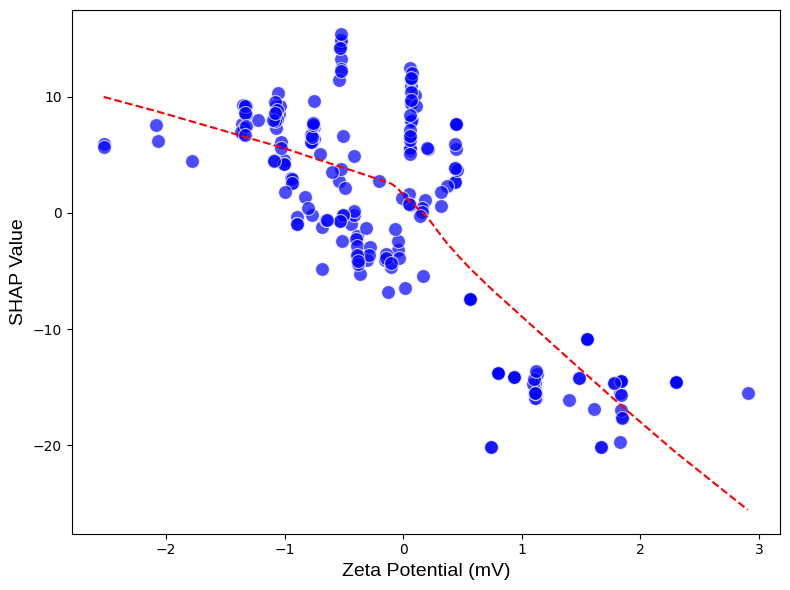

In [ ]:
def plot_shap_ZP():
    plt.figure(figsize=(8, 6))

    shap_values_ZP = shap_df["ZP"]

    sns.scatterplot(
        x = X_plot['ZP'],
        y=shap_values_ZP,
        color = 'blue',
        s = 100,
        alpha=0.7
    )

    # Add trend line
    import statsmodels.api as sm
    trend = sm.nonparametric.lowess(shap_values_ZP, X_plot['ZP'],
                                frac=0.8,
                                it=0)
    plt.plot(trend[:, 0], trend[:, 1], color='red', linestyle='--', label='Trend')

    plt.xlabel("Zeta Potential (mV)", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    plt.ylabel("SHAP Value", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    #plt.title("SHAP Dependence Plot for Hydrodynamic Size", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

plot_shap_ZP()

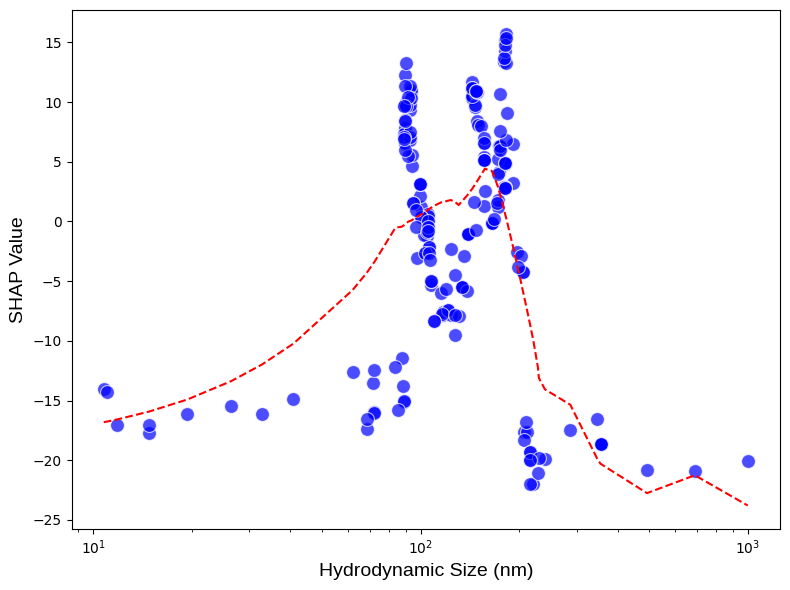

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare grouped SHAP data
X_plot = pd.DataFrame(grouped_shap_full.data, columns=grouped_shap_full.feature_names)
shap_df = pd.DataFrame(grouped_shap_full.values, columns=grouped_shap_full.feature_names)

def plot_shap_logHD_linear_scale():
    plt.figure(figsize=(8, 6))

    # Apply inverse log (10^x if log base 10, or exp(x) for natural log)

    HD_linear = 10 ** X_plot["logHD"]

    shap_values_logHD = shap_df["logHD"]

    sns.scatterplot(
        x=HD_linear,
        y=shap_values_logHD,
        color = 'blue',
        s = 100,
        alpha=0.7
    )

    # Add trend line (optional)
    import statsmodels.api as sm
    trend = sm.nonparametric.lowess(shap_values_logHD, HD_linear)
    plt.plot(trend[:, 0], trend[:, 1], color='red', linestyle='--', label='Trend')

    plt.xlabel("Hydrodynamic Size (nm)", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    plt.ylabel("SHAP Value", fontsize=14, fontfamily = "Liberation Sans", color = "black")
    plt.xscale('log')
    #plt.title("SHAP Dependence Plot for Hydrodynamic Size", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

plot_shap_logHD_linear_scale()


/tmp/ipython-input-25-2333945440.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group["SHAP Value"].values for _, group in shap_logHD_df.groupby("Hydrodynamic Size Category")]
/tmp/ipython-input-25-2333945440.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


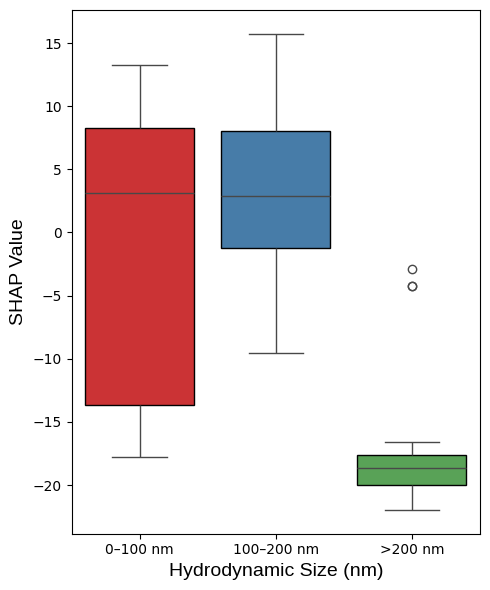

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# Convert logHD to linear scale (HD in nm)
HD_linear = 10 ** X_plot["logHD"]

# Define new bins and labels
bins = [0, 100, 200, np.inf]
labels = ['0–100 nm', '100–200 nm', '>200 nm']
HD_categories = pd.cut(HD_linear, bins=bins, labels=labels, include_lowest=True)

# Create DataFrame for analysis
shap_logHD_df = pd.DataFrame({
    "Hydrodynamic Size Category": HD_categories,
    "SHAP Value": shap_df["logHD"]
})

# Statistical test (Kruskal-Wallis)
groups = [group["SHAP Value"].values for _, group in shap_logHD_df.groupby("Hydrodynamic Size Category")]
stat, p = kruskal(*groups)

# Visualization
plt.figure(figsize=(5, 6))
sns.boxplot(
    data=shap_logHD_df,
    x="Hydrodynamic Size Category",
    y="SHAP Value",
    palette='Set1',
    boxprops=dict(edgecolor='black')
)
plt.xlabel("Hydrodynamic Size (nm)", fontsize=14, fontfamily = "Liberation Sans", color = "black")
plt.ylabel("SHAP Value", fontsize=14, fontfamily = "Liberation Sans", color = "black")
plt.tight_layout()
plt.show()


In [ ]:
!pip install scikit-posthocs

In [ ]:
import scikit_posthocs as sp

# Dunn’s test with Bonferroni correction
posthoc_results = sp.posthoc_dunn(
    shap_logHD_df,
    val_col='SHAP Value',
    group_col='Hydrodynamic Size Category',
    p_adjust='bonferroni'
)

posthoc_results

,0–100 nm,100–200 nm,>200 nm
0–100 nm,1.000000e+00,8.350926e-01,3.245440e-10
100–200 nm,8.350926e-01,1.000000e+00,5.077457e-14
>200 nm,3.245440e-10,5.077457e-14,1.000000e+00


In [ ]:
#convert grouped_shap_full to a dataframe
shap_df_full = pd.DataFrame(grouped_shap_full.values, columns = grouped_shap_full.feature_names)

# Identify the one-hot encoded MAT columns
mat_cols = [col for col in X_full.columns if col.startswith('MAT_')]

# Label the MAT
materials_labels = X_full[mat_cols].idxmax(axis=1)
maberials_labels = materials_labels.str.replace("MAT_", "")

shap_mat_df = pd.DataFrame({
    "MAT": materials_labels,
    "SHAP_MAT": shap_df_full["MAT"]
})

MAT_df = shap_mat_df.groupby(["MAT"])['SHAP_MAT'].mean().reset_index()
MAT_df["MAT"] = MAT_df["MAT"].str.replace("MAT_", "")

In [ ]:
import scipy.stats as stats
groups = [
    grp["SHAP_MAT"].values
    for _, grp in shap_mat_df.groupby("MAT")
]

# Run Kruskal–Wallis
h_stat, p_value = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_value:.8f}")


Kruskal–Wallis H = 169.854, p = 0.00000000


In [ ]:
posthoc = sp.posthoc_dunn(
    shap_mat_df,
    val_col="SHAP_MAT",
    group_col="MAT",
    p_adjust="bonferroni"
)
print(posthoc)

                          MAT_Gold  MAT_Hybrid  MAT_Inorganic others  \
MAT_Gold              1.000000e+00    1.000000              1.000000   
MAT_Hybrid            1.000000e+00    1.000000              1.000000   
MAT_Inorganic others  1.000000e+00    1.000000              1.000000   
MAT_Iron              1.000000e+00    1.000000              1.000000   
MAT_Liposome          1.000000e+00    1.000000              1.000000   
MAT_Organic others    1.000000e+00    1.000000              1.000000   
MAT_Polymeric         1.966659e-29    0.025923              0.016463   
MAT_Silica            1.000000e+00    1.000000              1.000000   

                      MAT_Iron  MAT_Liposome  MAT_Organic others  \
MAT_Gold                   1.0  1.000000e+00            1.000000   
MAT_Hybrid                 1.0  1.000000e+00            1.000000   
MAT_Inorganic others       1.0  1.000000e+00            1.000000   
MAT_Iron                   1.0  1.000000e+00            1.000000   
MAT_Liposom

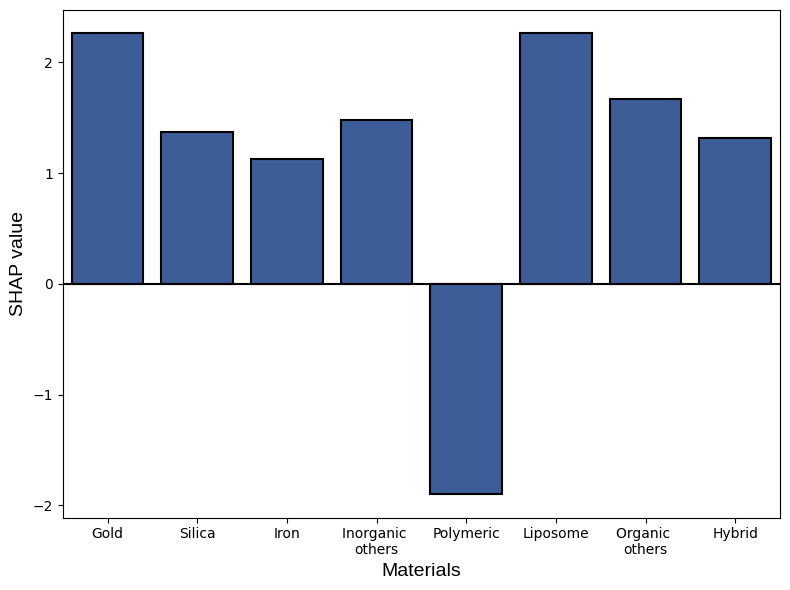

In [ ]:
plt.figure(figsize=(8, 6))

shap_df_full = pd.DataFrame(
    grouped_shap_full.values,
    columns=grouped_shap_full.feature_names
)

# identify one-hot columns for MAT
mat_cols = [c for c in X_full.columns if c.startswith("MAT_")]

materials = (
    X_full[mat_cols]
      .idxmax(axis=1)          # pick the hot one
      .str.replace("MAT_", "") # strip prefix
)

shap_mat_df = pd.DataFrame({
    "MAT": materials,
    "SHAP_MAT": shap_df_full["MAT"]
})
group_stats = (
    shap_mat_df
      .groupby("MAT")["SHAP_MAT"]
      .agg(["mean", "std"])
      .reset_index()
)

ax = sns.barplot(
    x="MAT",
    y="mean",
    data=group_stats,
    color = "#2e59a7",
    order= ['Gold', 'Silica', 'Iron', 'Inorganic others', 'Polymeric', 'Liposome', 'Organic others', 'Hybrid'],
    edgecolor='black',
    linewidth=1.5
)

new_labels = ['Gold', 'Silica', 'Iron', 'Inorganic \nothers', 'Polymeric', 'Liposome', 'Organic \nothers', 'Hybrid']
ax.set_xticklabels(new_labels)

plt.axhline(0, color='black', linewidth=1.5, linestyle='-')
plt.xlabel("Materials", fontsize=14, fontfamily="Liberation Sans", color = "black")
plt.ylabel("SHAP value", fontsize=14, fontfamily="Liberation Sans", color = "black")
plt.tight_layout()
plt.show()

In [ ]:
# Save X_train_selected, X_test_selected and X_scaled
X_train_selected.to_csv(os.path.join(root_dir + project_folder, "X_train_selected_CREA.csv"), index=False)
X_test_selected.to_csv(os.path.join(root_dir + project_folder, "X_test_selected_CREA.csv"), index=False)
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)
X_scaled.to_csv(os.path.join(root_dir + project_folder, "X_scaled_CREA.csv"), index=False)

In [ ]:
# Save y_train and y_test
y_train.to_csv(os.path.join(root_dir + project_folder, "y_train_CREA.csv"), index=False)
y_test.to_csv(os.path.join(root_dir + project_folder, "y_test_CREA.csv"), index=False)

In [ ]:
# Loading X_train_selected, X_test_selected, and X_scaled
X_train_selected = pd.read_csv(os.path.join(root_dir + project_folder, "X_train_selected_CREA.csv"))
X_test_selected = pd.read_csv(os.path.join(root_dir + project_folder, "X_test_selected_CREA.csv"))
X_scaled = pd.read_csv(os.path.join(root_dir + project_folder, "X_scaled_CREA.csv"))
y_train = pd.read_csv(os.path.join(root_dir + project_folder, "y_train_CREA.csv"))
y_test = pd.read_csv(os.path.join(root_dir + project_folder, "y_test_CREA.csv"))
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()